In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.special import voigt_profile
from scipy.integrate import trapz
import pandas as pd
import numpy as np

In [2]:
def normalize(arr_x,arr_y):
    arr_y/=np.sqrt(trapz(arr_y**2,arr_x))
    return arr_y

In [3]:
en_x = np.linspace(8000,8080,1001)
en_x_beam=np.linspace(8950,9050,10001)
exp_res=0
beam_width=0.5

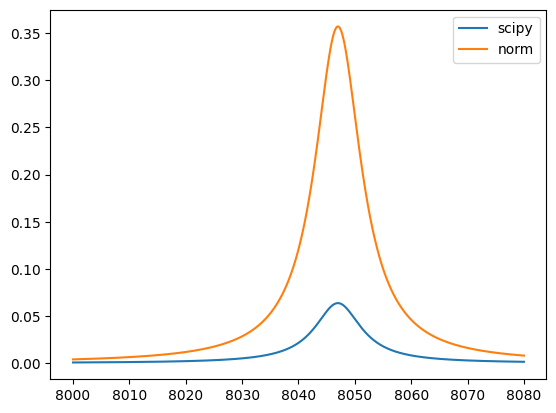

In [4]:
plt.plot(en_x,voigt_profile(en_x-8047,0,5),label='scipy')
plt.plot(en_x,normalize(en_x,voigt_profile(en_x-8047,0,5)),label='norm')
plt.legend()

In [5]:
def get_spectrum(orbital,beam_profile):
    df_arr = pd.read_csv(f'data/Cu_{orbital}_spectrum_diagram.csv')[['Initial Config Label','Initial Config 2jj','Initial Config eig','Final Config Label','Final Config 2jj','Final Config eig','Energy (eV)','Intensity (a.u.)','Energy width (eV)']]
    df_rate = pd.read_csv(f'data/Cu_{orbital}_rates_rad.csv')[['Initial Config Label','Initial Config 2jj','Initial Config eig','Final Config Label','Final Config 2jj','Final Config eig','Energy (eV)','Rate (s-1)']]
    np_arr = df_arr.values
    np_rate = df_rate.values
    spec_arr=0*en_x

    for i in range(len(np_arr)):
        if np_arr[i][6]>en_x[0] and np_arr[i][6]<en_x[-1]:
            trans=voigt_profile(en_x-np_arr[i][6],exp_res,np_arr[i][8])*np_arr[i][7]
            overlap=0
            for j in range(len(np_rate)):
                if np_arr[i][0].strip() == np_rate[j][0].strip() and np_arr[i][1] == np_rate[j][1] and np_arr[i][2] == np_rate[j][2] and np_rate[j][3].strip()==orbital:
                    trans_pop = normalize(en_x_beam,voigt_profile(en_x_beam-np_rate[j][6],0,np_rate[j][7]*6.582119569E-16))
                    overlap = trapz(trans_pop * beam_profile,en_x_beam)*np_rate[j][7]
                    break
            spec_arr+=trans*np_arr[i][7]*overlap
    return spec_arr

In [6]:
def spec_beam_en(beam_en,orbitals):
    beam_profile = normalize(arr_y=voigt_profile(en_x_beam-beam_en,beam_width,0),arr_x=en_x_beam)
    spec_dict={}
    tot_spec=0*en_x
    for key in orbitals:
        spec_dict[key] = get_spectrum(key,beam_profile)
        tot_spec+= spec_dict[key]
        #plt.plot(en_x,spec_dict[key])z
    return tot_spec



In [7]:
en_arr=np.linspace(8970,8995,31)

data=np.empty(len(en_arr),dtype=object)
from IPython.display import display, clear_output
for i in range(len(en_arr)):
    data[i] = spec_beam_en(en_arr[i],['4s','4p','4d','4f','5s','5p','5d','5f','5g','6s','6p','6d','6f'])
    clear_output(wait=True)
    display(f"Iteration: {i}")
    
    
    


'Iteration: 30'

Locator attempting to generate 1001 ticks ([8970.0, ..., 8995.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1001 ticks ([8000.0, ..., 8080.0]), which exceeds Locator.MAXTICKS (1000).


<Figure size 432x288 with 0 Axes>

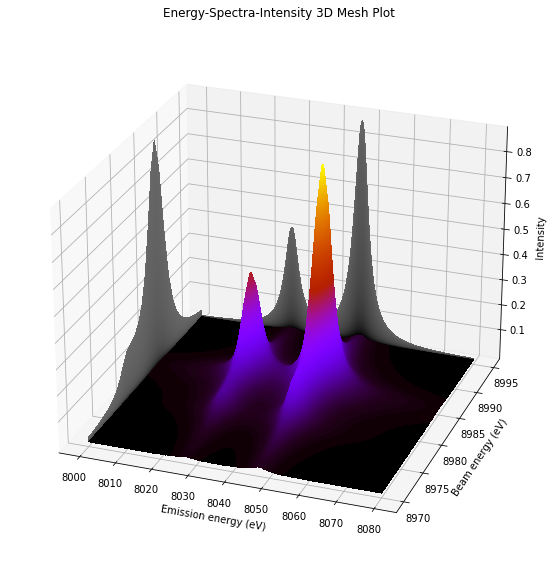

In [8]:
plt.tight_layout()
# Create a 3D plot
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d',computed_zorder=False)


en_grid , beam_en_grid = np.meshgrid(en_x,en_arr)
mesh_data = 0*en_grid
for i in range(len(en_grid)):
    mesh_data[i]=data[i]

ax.contourf(en_grid,beam_en_grid,np.log10(mesh_data),zdir='y',offset=en_arr[-1],levels=len(data[0]),cmap='binary',zorder=0)
ax.contourf(en_grid,beam_en_grid,np.log10(mesh_data),zdir='x',offset=en_x[0],levels=len(data[0]),cmap='binary',zorder=0)
ax.contourf(en_grid,beam_en_grid,mesh_data,levels=len(data[0]),cmap='gnuplot',zorder=10,antialiased=False)

# Set labels and title
ax.set_xlabel('Emission energy (eV)')
ax.set_ylabel('Beam energy (eV)')
ax.set_zlabel('Intensity')
ax.set_title('Energy-Spectra-Intensity 3D Mesh Plot')

# Show the plot
ax.view_init(elev=25,azim=-70)
ax.set_rasterized(True)
fig.savefig('3Dplot.pdf',dpi=250,format='pdf',bbox_inches='tight')
plt.show()


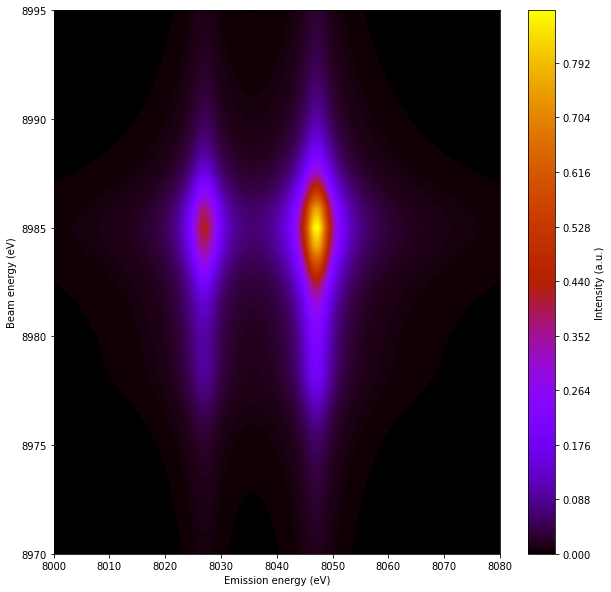

In [9]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot()

contour=ax.contourf(en_grid,beam_en_grid,mesh_data,levels=len(data[0]),cmap='gnuplot',antialiased=False)
cbar = plt.colorbar(contour)
cbar.set_label('Intensity (a.u.)')

ax.set_xlabel('Emission energy (eV)')
ax.set_ylabel('Beam energy (eV)')
ax.set_rasterized(True)
fig.savefig('2Dplot.pdf',dpi=300)

### Orbital 4s

In [7]:
def plot_spectra(orbitals):

    en_arr=np.linspace(8970,8995,301)

    data=np.empty(len(en_arr),dtype=object)
    from IPython.display import display, clear_output
    for i in range(len(en_arr)):
        data[i] = spec_beam_en(en_arr[i],orbitals)
        clear_output(wait=True)
        display(f"{orbitals}, Iteration: {i}")

    fig = plt.figure(figsize=(10,20))
    fig.suptitle('_'.join(orbitals) + ' spectator electron',fontsize=16)

    ax_3D = fig.add_subplot(2,1,1,projection='3d',computed_zorder=False)
    ax_2D = fig.add_subplot(2,1,2)

    en_grid , beam_en_grid = np.meshgrid(en_x,en_arr)
    mesh_data = 0*en_grid
    for i in range(len(en_grid)):
        mesh_data[i]=data[i]
    

    ax_3D.contourf(en_grid,beam_en_grid,mesh_data,zdir='y',offset=en_arr[-1],levels=len(data[0]),cmap='binary',zorder=0)
    ax_3D.contourf(en_grid,beam_en_grid,mesh_data,zdir='x',offset=en_x[0],levels=len(data[0]),cmap='binary',zorder=0)
    ax_3D.contourf(en_grid,beam_en_grid,mesh_data,levels=len(data[0]),cmap='nipy_spectral',zorder=10,antialiased=False)

    # Set labels and title
    ax_3D.set_xlabel('Emission energy (eV)')
    ax_3D.set_ylabel('Beam energy (eV)')
    ax_3D.set_zlabel('Intensity')


    # Show the plot
    ax_3D.view_init(elev=25,azim=-70)
    ax_3D.set_rasterized(True)


    contour_2D=ax_2D.contourf(en_grid,beam_en_grid,mesh_data,levels=len(data[0]),cmap='nipy_spectral',antialiased=False)
    cbar = plt.colorbar(contour_2D)
    cbar.set_label('Intensity (a.u.)')

    ax_2D.set_xlabel('Emission energy (eV)')
    ax_2D.set_ylabel('Beam energy (eV)')
    ax_2D.set_rasterized(True)

    fig.tight_layout()
    fig.savefig('figs/'+'_'.join(orbitals)+'.pdf',dpi=150,format='pdf')
    plt.close()



    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d',computed_zorder=False)


    ax.contourf(en_grid,beam_en_grid,mesh_data,zdir='y',offset=en_arr[-1],levels=len(data[0]),cmap='binary',zorder=0)
    ax.contourf(en_grid,beam_en_grid,mesh_data,zdir='x',offset=en_x[0],levels=len(data[0]),cmap='binary',zorder=0)
    ax.contourf(en_grid,beam_en_grid,mesh_data,levels=len(data[0]),cmap='nipy_spectral',zorder=10,antialiased=False)

    # Set labels and title
    ax.set_xlabel('Emission energy (eV)')
    ax.set_ylabel('Beam energy (eV)')
    ax.set_zlabel('Intensity')
    ax.set_title('Energy-Spectra-Intensity 3D Mesh Plot')

    # Show the plot
    ax.view_init(elev=25,azim=-70)
    ax.set_rasterized(True)
    fig.savefig('figs_3D/'+'_'.join(orbitals)+'.pdf',dpi=200,format='pdf',bbox_inches='tight')
    plt.close()


    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot()

    contour=ax.contourf(en_grid,beam_en_grid,mesh_data,levels=len(data[0]),cmap='nipy_spectral',antialiased=False)
    cbar = plt.colorbar(contour)
    cbar.set_label('Intensity (a.u.)')

    ax.set_xlabel('Emission energy (eV)')
    ax.set_ylabel('Beam energy (eV)')
    ax.set_rasterized(True)
    fig.savefig('figs_2D/'+'_'.join(orbitals)+'.pdf',dpi=300)

    plt.close()
    

In [10]:
for i in [['4s'],['4p'],['4d'],['4f'],['5s'],['5p'],['5d'],['5f'],['5g'],['6s'],['6p'],['6d'],['6f'],['6g'],['4s','4p','4d','4f','5s','5p','5d','5f','5g','6s','6p','6d','6f','6g']]:
    plot_spectra(i)
#plot_spectra(['4s','4p','4d','4f','5s','5p','5d','5f','5g','6s','6p','6d','6f','6g'])
#plot_spectra(['4p'])

"['4s', '4p', '4d', '4f', '5s', '5p', '5d', '5f', '5g', '6s', '6p', '6d', '6f', '6g'], Iteration: 300"

Locator attempting to generate 1001 ticks ([8970.0, ..., 8995.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1001 ticks ([8000.0, ..., 8080.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1001 ticks ([8970.0, ..., 8995.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1001 ticks ([8000.0, ..., 8080.0]), which exceeds Locator.MAXTICKS (1000).
